In [70]:
import numpy as np
import pandas as pd
from scipy.stats import entropy
import os
import re
import matplotlib.pyplot as plt
from itertools import combinations
from numpy import dot
from numpy.linalg import norm
import math

In [60]:
def parse_hmm(file_path: str, n_promoters: int) -> list:
    ### Yields a matrix of n*m, where n - base pair length of a sequence , m - 4 nucleotides (A,T,C,G)
    n = [str(x) for x in list(range(0,n_promoters + 1))]
    promoter_list = []
    
    with open(file_path, "rt") as file:
        for line in file:
            line = line.split()
            if line[0] in n:
                promoter_list.append(line[1:5])
    return promoter_list

def convert_to_probability(hmm_scores: list, background_probability: float):
    ### Yields a matrix of n*m, where n - base pair length of a sequence , m - 4 nucleotides (A,T,C,G)
    probabilities_list = []
    
    for position in hmm_scores:
        ### Cinverting from log-odds to the regular probabilities
        probabilities = [background_probability * np.exp(float(score)) for score in position]
        ### Normalizing regular probabilities
        probabilities = [p / sum(probabilities) for p in probabilities]
        
        probabilities_list.append(probabilities)
    
    return np.array(probabilities_list)

def js_divergence(profile1, profile2):
    
    js_divergences = []
    
    for pos in range(profile1.shape[0]): 

        # The midpoint probability distribution 
        midpoint = 0.5 * (profile1[pos] + profile2[pos])
        
        # Calculate JS divergence as the average of KL divergence to the midpoint
        kl1 = entropy(profile1[pos], midpoint, base=2)  # KL(profile1 || midpoint)
        kl2 = entropy(profile2[pos], midpoint, base=2)  # KL(profile2 || midpoint)
        js = 0.5 * (kl1 + kl2) 
        js_divergences.append(js)
    
    return np.array(js_divergences)

In [76]:
athaliana = parse_hmm("hmm_profiles/athaliana_200_hmm_profile.txt", 401)
athaliana = convert_to_probability(athaliana, 0.25)

hsapiens = convert_to_probability(parse_hmm("hmm_profiles/hsapiens_200_hmm_profile.txt", 401), 0.25)
dmelanogaster = convert_to_probability(parse_hmm("hmm_profiles/dmelanogaster_200_hmm_profile.txt", 401), 0.25)
celegans = convert_to_probability(parse_hmm("hmm_profiles/celegans_200_hmm_profile.txt", 401), 0.25)
pfalciparum = convert_to_probability(parse_hmm("hmm_profiles/pfalciparum_200_hmm_profile.txt", 401), 0.25)
scerevisiae = convert_to_probability(parse_hmm("hmm_profiles/scerevisiae_200_hmm_profile.txt", 401), 0.25)

hsapiens_athaliana_js = js_divergence(athaliana, hsapiens)
hsapiens_dmelanogaster_js = js_divergence(hsapiens, dmelanogaster)
hsapiens_celegans_js = js_divergence(hsapiens, celegans)
hsapiens_pfalciparum_js = js_divergence(hsapiens, pfalciparum)
hsapiens_scerevisiae_js = js_divergence(hsapiens, scerevisiae)



In [74]:
hs = hsapiens[0]
atha = athaliana[0]

mid = 0.5 * (hs + atha)

summa = 0
for i in range(4):
    one = hs[i] * math.log((hs[i]/mid[i]), 2)
    two = atha[i] * math.log((atha[i]/mid[i]), 2)
    three = 0.5 * (one + two)
    summa += three
print(summa)


kl1 = entropy(hs, mid, base=2)  
kl2 = entropy(atha, mid, base=2) 
ent = 0.5 * (kl1 + kl2) 
print(ent)
print(hsapiens_athaliana_js[0])

0.048405308925237776
0.04840530892523809
0.04840530892523809


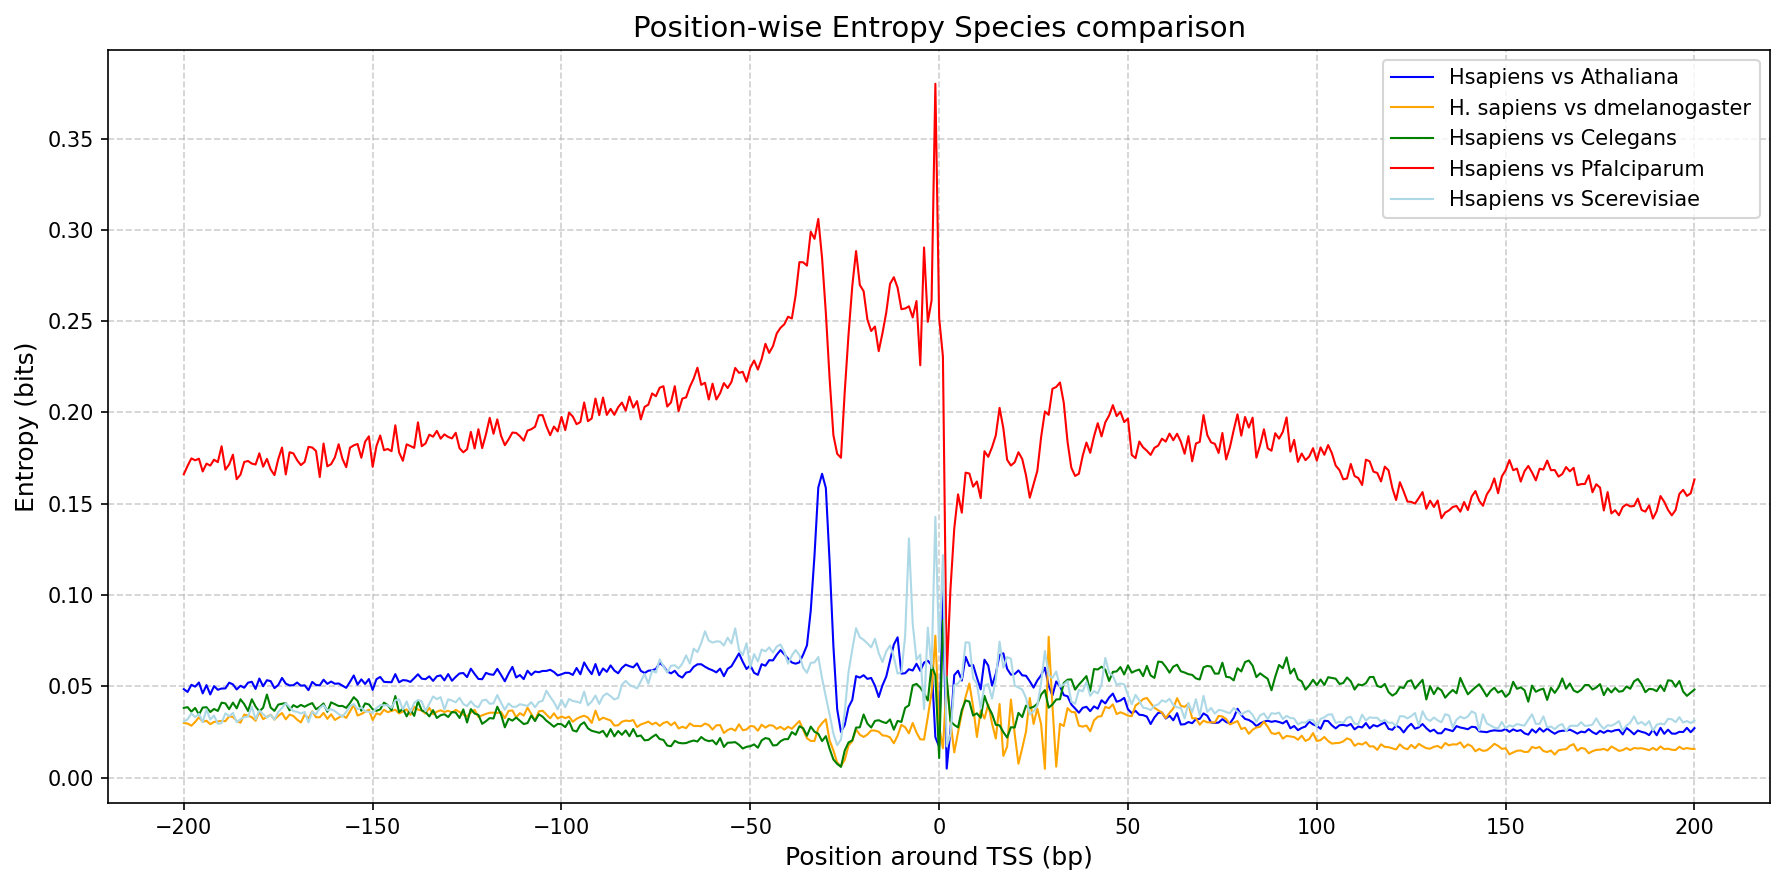

In [79]:
positions = np.arange(-200,201)


plt.figure(figsize=(12, 6), dpi=150) 

plt.plot(positions, hsapiens_athaliana_js, label="Hsapiens vs Athaliana", color="blue", linewidth=1)
plt.plot(positions, hsapiens_dmelanogaster_js, label="H. sapiens vs dmelanogaster", color="orange", linewidth=1)
plt.plot(positions, hsapiens_celegans_js, label="Hsapiens vs Celegans", color="green", linewidth=1)
plt.plot(positions, hsapiens_pfalciparum_js, label="Hsapiens vs Pfalciparum", color="red", linewidth=1)
plt.plot(positions, hsapiens_scerevisiae_js , label="Hsapiens vs Scerevisiae", color="lightblue", linewidth=1)



plt.title("Position-wise Entropy Species comparison", fontsize=14)
plt.xlabel("Position around TSS (bp)", fontsize=12)
plt.ylabel("Entropy (bits)", fontsize=12)

plt.legend(loc="upper right", fontsize=10)

plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


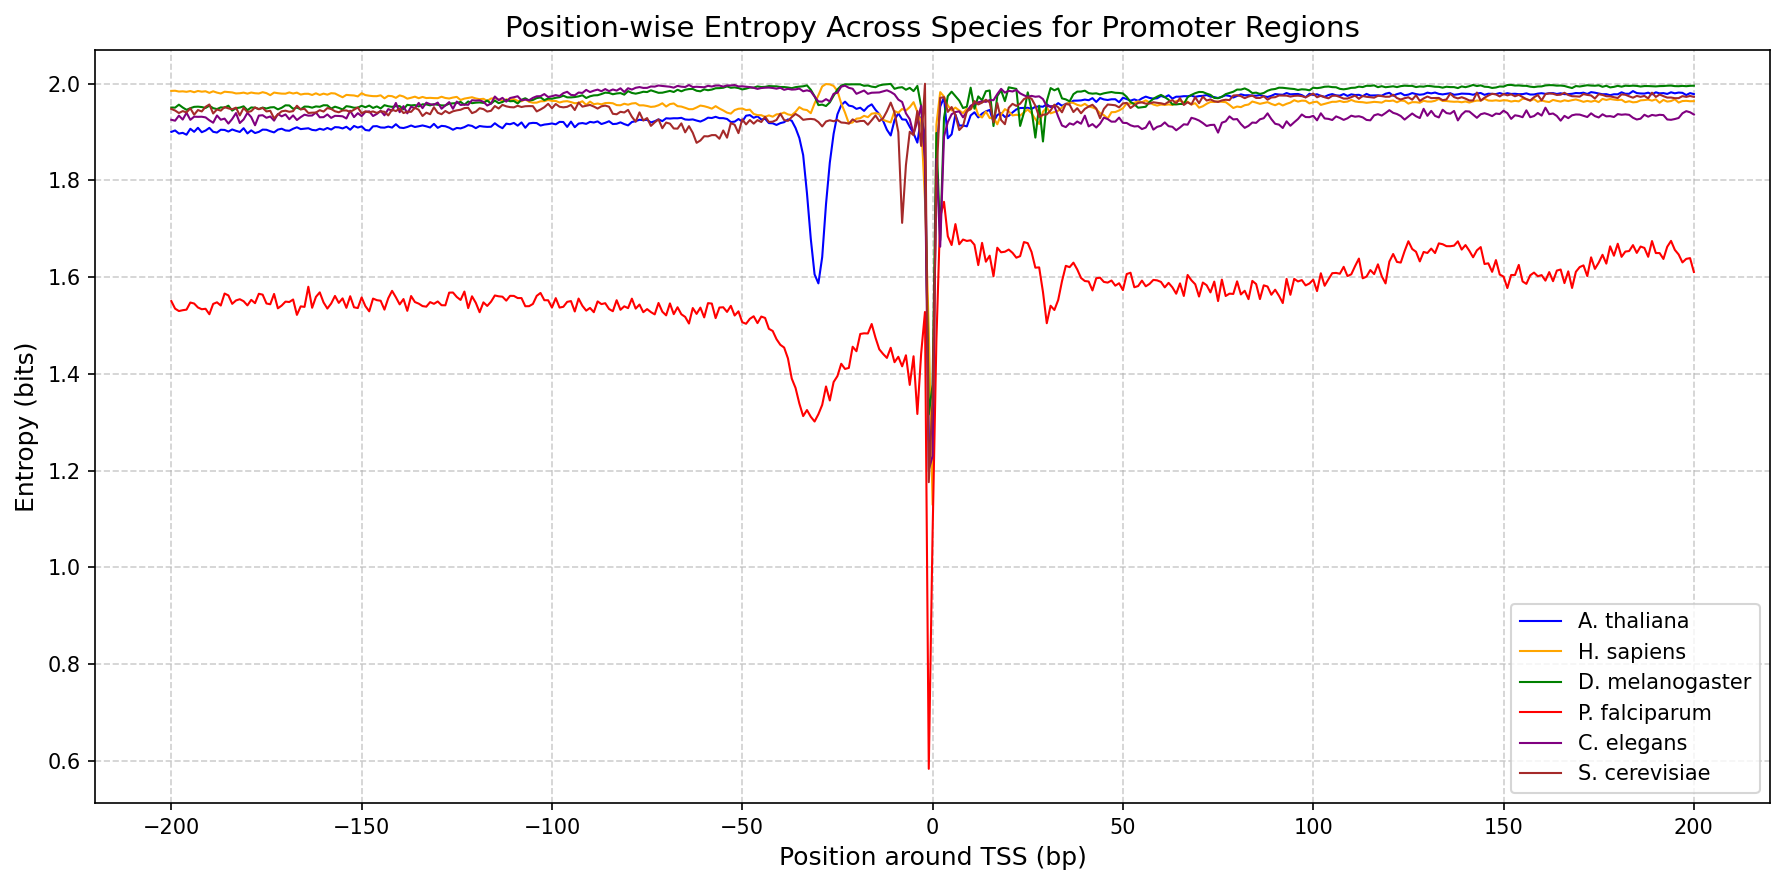

In [57]:
positions = np.arange(-200,201)



athaliana_entropy = np.apply_along_axis(entropy, axis=1, arr=athaliana, base=2)
hsapiens_entropy = np.apply_along_axis(entropy, axis=1, arr=hsapiens, base=2)
dmelanogaster_entropy = np.apply_along_axis(entropy, axis=1, arr=dmelanogaster, base=2)
pfalciparum_entropy = np.apply_along_axis(entropy, axis=1, arr=pfalciparum, base=2)
celegans_entropy = np.apply_along_axis(entropy, axis=1, arr=celegans, base=2)
scerevisiae_entropy = np.apply_along_axis(entropy, axis=1, arr=scerevisiae, base=2)


plt.figure(figsize=(12, 6), dpi=150)  # Increase figure size and resolution

plt.plot(positions, athaliana_entropy, label="A. thaliana", color="blue", linewidth=1)
plt.plot(positions, hsapiens_entropy, label="H. sapiens", color="orange", linewidth=1)
plt.plot(positions, dmelanogaster_entropy, label="D. melanogaster", color="green", linewidth=1)
plt.plot(positions, pfalciparum_entropy, label="P. falciparum", color="red", linewidth=1)
plt.plot(positions, celegans_entropy, label="C. elegans", color="purple", linewidth=1)
plt.plot(positions, scerevisiae_entropy, label="S. cerevisiae", color="brown", linewidth=1)

plt.title("Position-wise Entropy Across Species for Promoter Regions", fontsize=14)
plt.xlabel("Position around TSS (bp)", fontsize=12)
plt.ylabel("Entropy (bits)", fontsize=12)

plt.legend(loc="lower right", fontsize=10)

plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

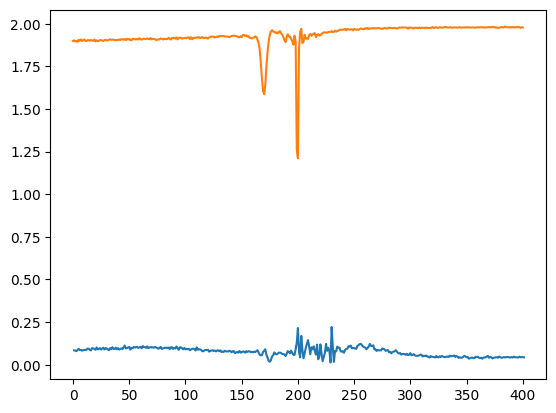

In [85]:
n = 6
species = ["athaliana", "celegans", "dmelanogaster", "hsapiens", "pfalciparum", "scerevisiae"]
similarity_matrix = np.zeros((n, n))

for i in range(n):
    profile1 = convert_to_probability(parse_hmm("hmm_profiles/" + species[i] + "_200_hmm_profile.txt", 401), 0.25)
    for j in range(i, n):
        profile2 = convert_to_probability(parse_hmm("hmm_profiles/" + species[j] + "_200_hmm_profile.txt", 401), 0.25)
        
        divergence = kl_divergence(profile1, profile2).mean()
        similarity_matrix[i, j] = divergence
        similarity_matrix[j, i] = divergence


similarity_df = pd.DataFrame(similarity_matrix, index=species, columns=species)
print(similarity_df)




               athaliana  celegans  dmelanogaster  hsapiens  pfalciparum  \
athaliana       0.000000  0.019806       0.018296  0.128851     0.195374   
celegans        0.019806  0.000000       0.018266  0.113129     0.228063   
dmelanogaster   0.018296  0.018266       0.000000  0.076483     0.264441   
hsapiens        0.128851  0.113129       0.076483  0.000000     0.624605   
pfalciparum     0.195374  0.228063       0.264441  0.624605     0.000000   
scerevisiae     0.016424  0.026868       0.015053  0.124228     0.153456   

               scerevisiae  
athaliana         0.016424  
celegans          0.026868  
dmelanogaster     0.015053  
hsapiens          0.124228  
pfalciparum       0.153456  
scerevisiae       0.000000  


In [3]:
data = pd.read_csv("combined_dna_shape_table.csv")


In [ ]:
n = 6
species = ["athaliana", "celegans", "dmelanogaster", "hsapiens", "pfalciparum", "scerevisiae"]
similarity_matrix = np.zeros((n, n))
similarity_df = pd.DataFrame(columns=["species1", "species2", "position", "kl_value"])

for i in range(n):
    profile1 = convert_to_probability(parse_hmm("hmm_profiles/" + species[i] + "_200_hmm_profile.txt", 401), 0.25)

    for j in range(i, n):
        profile2 = convert_to_probability(parse_hmm("hmm_profiles/" + species[j] + "_200_hmm_profile.txt", 401), 0.25)
        
        divergence = kl_divergence(profile1, profile2)
        print(divergence)

        df = pd.DataFrame({
            'species1': [species[i]] * len(divergence),
            'species2': [species[j]] * len(divergence),
            'position': np.arange(-200, 201), 
            'kl_value': divergence
        })
        similarity_df = pd.concat([similarity_df, df], ignore_index=True)



In [95]:
similarity_df.to_csv("kl_divergence_table.csv", index=False)

In [14]:
shapes = pd.read_csv("combined_dna_shape_table.csv")

filtered_data = shapes[(shapes['source'] == 'raw') & (shapes['position'] >= -185) & (shapes['position'] <= 185)]

results = []

species_list = filtered_data['species'].unique()
property_list = filtered_data['property'].unique()


for prop in property_list:
    prop_data = filtered_data[filtered_data['property'] == prop]
    

    for species1, species2 in combinations(species_list, 2):

        values_species1 = prop_data[prop_data['species'] == species1]['value'].values
        values_species2 = prop_data[prop_data['species'] == species2]['value'].values
        

        if len(values_species1) == 371 and len(values_species2) == 371:
            cosine_similarity = dot(values_species1, values_species2) / (norm(values_species1) * norm(values_species2))

            results.append({
                'species1': species1,
                'species2': species2,
                'property': prop,
                'cosine_similarity': cosine_similarity
            })

similarity_df = pd.DataFrame(results)
print(similarity_df)

similarity_df.to_csv("cosine_shapes_similarity.csv", index=False)

          species1       species2 property  cosine_similarity
0        athaliana       celegans   Buckle           0.240127
1        athaliana  dmelanogaster   Buckle          -0.048825
2        athaliana       hsapiens   Buckle           0.451897
3        athaliana    pfalciparum   Buckle          -0.106003
4        athaliana    scerevisiae   Buckle          -0.085478
..             ...            ...      ...                ...
190  dmelanogaster    pfalciparum     Tilt           0.226252
191  dmelanogaster    scerevisiae     Tilt           0.303902
192       hsapiens    pfalciparum     Tilt           0.254655
193       hsapiens    scerevisiae     Tilt           0.261747
194    pfalciparum    scerevisiae     Tilt          -0.022864

[195 rows x 4 columns]


### How conserved the shapes across different species?
We calculate KL divergence in a pairwise species comparison

In [80]:
data = pd.read_csv("combined_dna_shape_table.csv")
data

,species,property,source,position,value,z_score,real_value
0,athaliana,Buckle,raw,-200,NaN,1.536227,6.805912
1,athaliana,Buckle,raw,-199,NaN,0.925341,4.124260
2,athaliana,Buckle,raw,-198,NaN,0.141638,0.671795
3,athaliana,Buckle,raw,-197,NaN,-0.000865,0.026892
4,athaliana,Buckle,raw,-196,NaN,0.051390,0.251275
...,...,...,...,...,...,...,...
93829,scerevisiae,Tilt,hmm,196,NaN,-0.036230,-0.072794
93830,scerevisiae,Tilt,hmm,197,NaN,0.021423,0.008237
93831,scerevisiae,Tilt,hmm,198,NaN,0.070972,0.077899
93832,scerevisiae,Tilt,hmm,199,NaN,-0.460930,-0.669774


In [89]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import jensenshannon

def calculate_js_divergence(data):
    """Calculate JS divergence between species for each property, using only rows where source == 'raw'.

    Args:
        data (pd.DataFrame): DataFrame with columns ['species', 'property', 'source', 'value'].

    Returns:
        pd.DataFrame: A DataFrame with JS divergence scores for each property pair across species.
    """
    
    results = []
    raw_data = data[data['source'] == 'raw']

    for prop, group in raw_data.groupby("property"):
        pivot_data = group.pivot(index='position', columns='species', values='z_score')
        pivot_data = pivot_data.dropna()

        species_list = pivot_data.columns
        for i, species1 in enumerate(species_list):
            for j, species2 in enumerate(species_list):
                if i < j:  
                  
                    shape1 = pivot_data[species1].values
                    shape2 = pivot_data[species2].values

                    if np.sum(shape1) == 0:
                        shape1 = shape1 + 1e-10
                    if np.sum(shape2) == 0:
                        shape2 = shape2 + 1e-10

                    p = shape1 / np.sum(shape1)
                    q = shape2 / np.sum(shape2)

                    try:
                        js_div = jensenshannon(p, q, base=2)
                    except ValueError:
                        js_div = np.nan
                    print(js_div)
                    
                    results.append({
                        "property": prop,
                        "species1": species1,
                        "species2": species2,
                        "js_divergence": js_div
                    })
                    
    return pd.DataFrame(results)

In [90]:
js_divergence_results = calculate_js_divergence(data)
print(js_divergence_results)

inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
nan
inf
inf
inf
nan
inf
inf
nan
inf
nan
nan
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
nan
nan
nan
nan
nan
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
    property       species1       species2  js_divergence
0     Buckle      athaliana       celegans            inf
1     Buckle      athaliana  dmelanogaster            inf
2     Buckle      athaliana       hsapiens    

/Users/tennisnyjmac/opt/anaconda3/lib/python3.9/site-packages/scipy/spatial/distance.py:1262: RuntimeWarning: divide by zero encountered in divide
  q = q / np.sum(q, axis=axis, keepdims=True)
/Users/tennisnyjmac/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/tennisnyjmac/opt/anaconda3/lib/python3.9/site-packages/scipy/spatial/distance.py:1261: RuntimeWarning: divide by zero encountered in divide
  p = p / np.sum(p, axis=axis, keepdims=True)
/Users/tennisnyjmac/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
